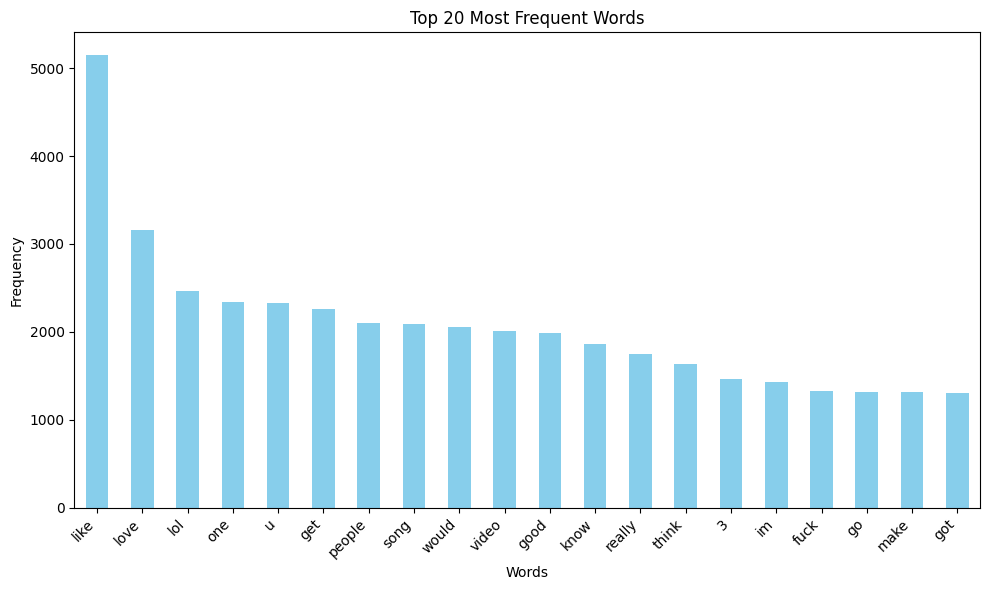


Sentiment Analysis Results:
                                                   Text  Sentiment_Polarity  \
0     Does N.e.bodyelse Hear her Crazy ass Screamin ...           -0.040000   
1     There are so many things that are incorrect wi...           -0.110606   
2     3:26 hahah my boyfriend showed this song to me...            0.433333   
3     dick beyonce fuck y a ass hole you are truely ...           -0.186975   
4     DongHaeTaemin and Kai ;A; luhansehun and bacon...            0.482143   
...                                                 ...                 ...   
3459  She pretty I love this song I miss the old kel...            0.304464   
3460  Status-Online Im ZxkillergirlzX! I'm Zxkillerg...            0.000000   
3461  JR so cute EXO M Better I agree like yeah yeah...            0.370833   
3462                                                ! !            0.000000   
3463  great video and MERRY CHRISTMAS from greece :*...            0.332612   

     Sentiment_Label  

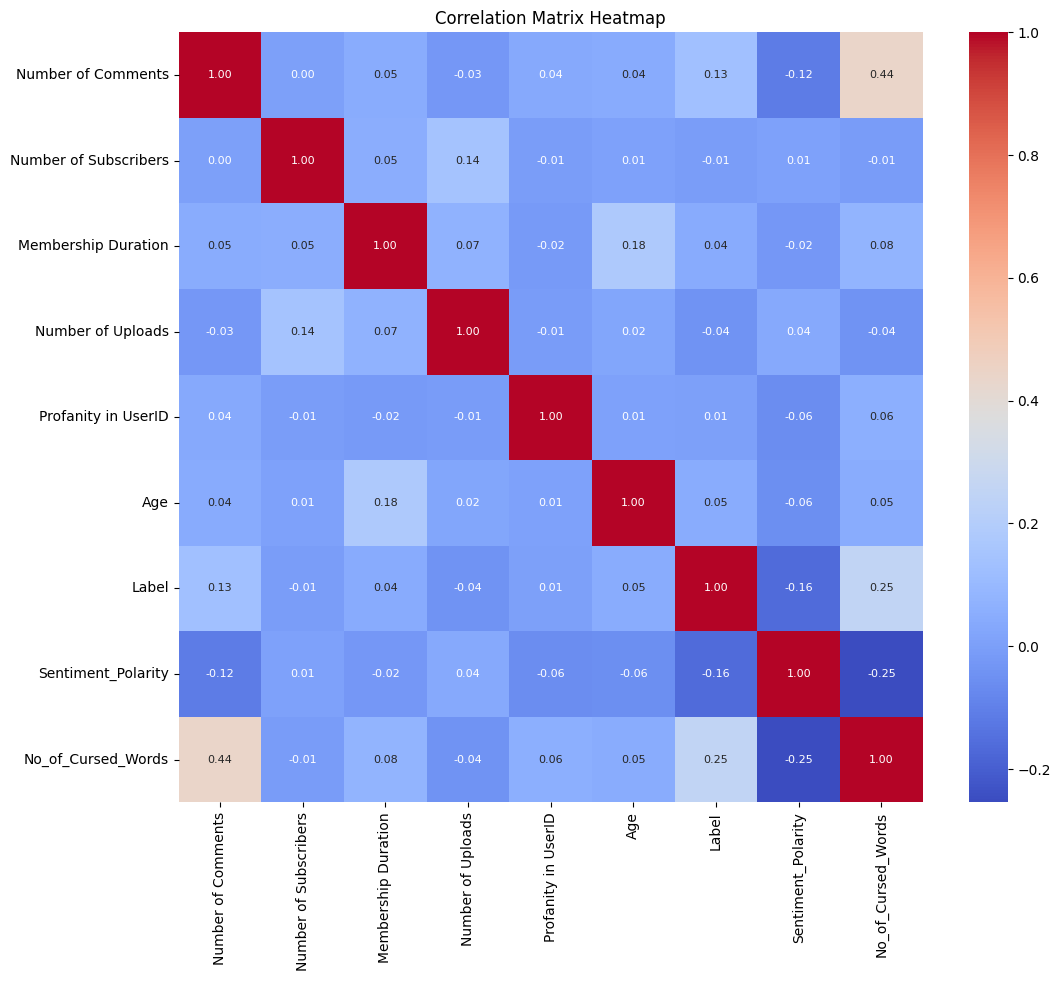


Numerical columns after feature selection: ['Number of Comments', 'Number of Subscribers', 'Membership Duration', 'Number of Uploads', 'Profanity in UserID', 'Age', 'Sentiment_Polarity', 'No_of_Cursed_Words']
[LightGBM] [Info] Number of positive: 2453, number of negative: 2422
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86395
[LightGBM] [Info] Number of data points in the train set: 4875, number of used features: 3557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503179 -> initscore=0.012718
[LightGBM] [Info] Start training from score 0.012718
Logistic Regression: Accuracy = 0.918785890073831, AUC = 0.9712888888888888
Random Forest: Accuracy = 0.9958982772764561, AUC = 0.9999622895622895
XGBoost: Accuracy = 0.948318293683347, AUC = 0.9883744107744108
LGBM: Accuracy = 0.9622641509433962, AUC = 0.9941872053872054
SVM: Accuracy = 0.9942575

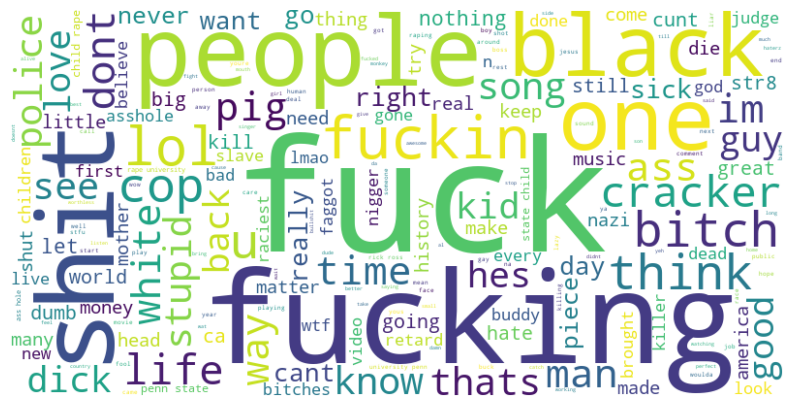

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

def predict_cyberbullying(X, y):
    # Train the classification model (you can use any model here)
    model = LogisticRegression()
    pipeline = build_pipeline(model)
    pipeline.fit(X, y)

    # Predict the labels for all texts
    y_pred = pipeline.predict(X)

    return y_pred

def generate_word_cloud(texts):
    # Combine all texts into a single string
    combined_text = ' '.join(texts)
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def nlp_pipeline(file_path, target_column='oh_label', text_column='Text'):
    # Read the dataset
    df = pd.read_csv(file_path)
    df = df.drop(['UserIndex', 'index'], axis=1)
    df.rename(columns={target_column: 'Label'}, inplace=True)
    
    # Text Preprocessing
    df['processed_text'] = df[text_column].apply(preprocess_text)
    
    # Word Frequency Visualization
    word_freq = df['processed_text'].str.split(expand=True).stack().value_counts().head(20)
    plt.figure(figsize=(10, 6))
    word_freq.plot(kind='bar', color='skyblue')
    plt.title('Top 20 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Sentiment Analysis
    df['Sentiment_Polarity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['Sentiment_Label'] = df['Sentiment_Polarity'].apply(lambda x: 'Positive' if x > 0 else ('Neutral' if x == 0 else 'Negative'))
    print("\nSentiment Analysis Results:")
    print(df[['Text', 'Sentiment_Polarity', 'Sentiment_Label']])
    
    # Feature Engineering
    cursed_words = ['fuck', 'shit', 'asshole', 'bitch', 'damn', 'crap', 'hell', 'bastard', 'piss', 'dick', 'pussy', 'mf', 'mother fucker', 'behenchod']
    df['No_of_Cursed_Words'] = df['Text'].apply(lambda x: sum(1 for word in x.lower().split() if word in cursed_words))
    
    # Correlation Matrix
    numeric_df = df.select_dtypes(include='number')
    corr_matrix = numeric_df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
    plt.title('Correlation Matrix Heatmap')
    plt.show()
    
    # Feature Selection
    numerical_columns = numeric_df.columns.tolist()
    if 'Label' in numerical_columns:
        numerical_columns.remove('Label')
    print("\nNumerical columns after feature selection:", numerical_columns)
    
    # Modeling
    X = df['processed_text']

    y = df['Label']
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    # Evaluate models
    results = evaluate_model(X_train.ravel(), X_test.ravel(), y_train, y_test)
    
    # Print results
    for name, accuracy, auc_score in results:
        print(f"{name}: Accuracy = {accuracy}, AUC = {auc_score}")
    
    # Predict cyberbullying and generate word cloud
    y_pred_cyberbullying = predict_cyberbullying(X, y)
    cyberbullying_texts = df.loc[y_pred_cyberbullying == 1, 'processed_text'].tolist()
    generate_word_cloud(cyberbullying_texts)

def build_pipeline(model):
    return Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', model)
    ])

def evaluate_model(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'LGBM': LGBMClassifier(),
        'SVM': SVC(probability=True),
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier()
    }

    results = []
    for name, model in models.items():
        pipeline = build_pipeline(model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if hasattr(model, 'predict_proba'):
            y_prob = pipeline.predict_proba(X_test)[:, 1]
            auc_score = roc_auc_score(y_test, y_prob)
        else:
            auc_score = None
        results.append((name, accuracy, auc_score))
    return results
# Example usage:
nlp_pipeline('cyberbullying/youtube_parsed_dataset.csv')


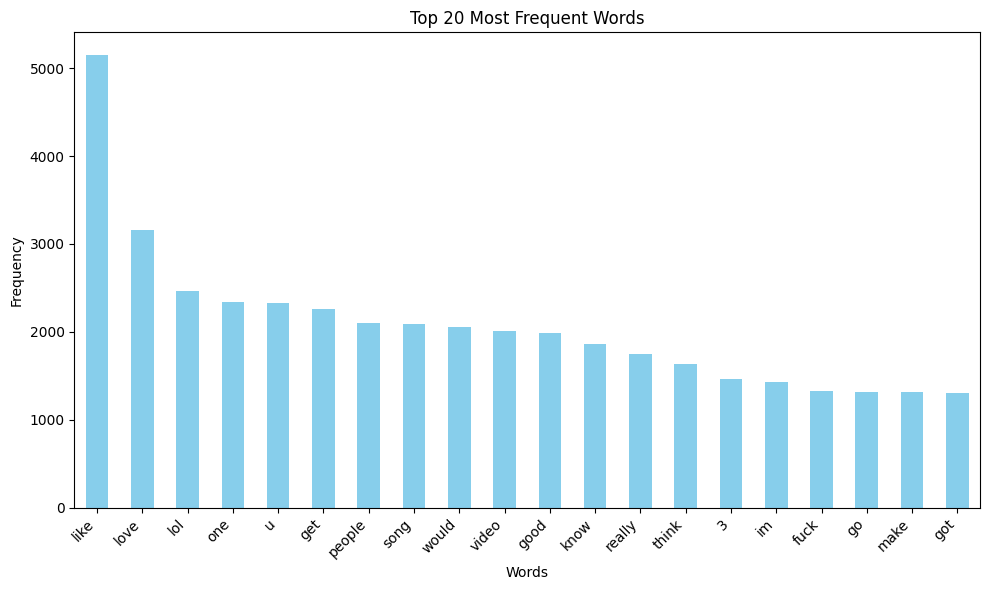


Sentiment Analysis Results:
                                                   Text  Sentiment_Polarity  \
0     Does N.e.bodyelse Hear her Crazy ass Screamin ...           -0.040000   
1     There are so many things that are incorrect wi...           -0.110606   
2     3:26 hahah my boyfriend showed this song to me...            0.433333   
3     dick beyonce fuck y a ass hole you are truely ...           -0.186975   
4     DongHaeTaemin and Kai ;A; luhansehun and bacon...            0.482143   
...                                                 ...                 ...   
3459  She pretty I love this song I miss the old kel...            0.304464   
3460  Status-Online Im ZxkillergirlzX! I'm Zxkillerg...            0.000000   
3461  JR so cute EXO M Better I agree like yeah yeah...            0.370833   
3462                                                ! !            0.000000   
3463  great video and MERRY CHRISTMAS from greece :*...            0.332612   

     Sentiment_Label  

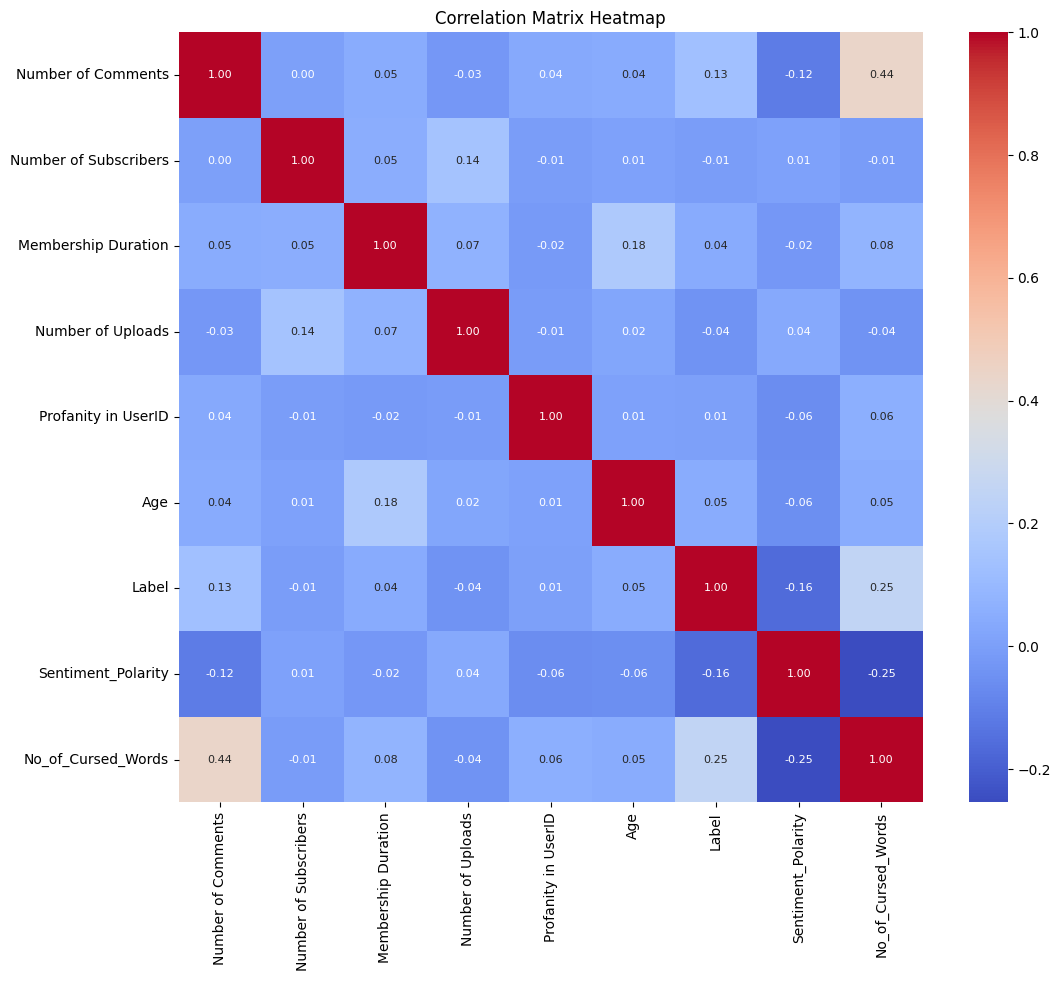


Numerical columns after feature selection: ['Number of Comments', 'Number of Subscribers', 'Membership Duration', 'Number of Uploads', 'Profanity in UserID', 'Age', 'Sentiment_Polarity', 'No_of_Cursed_Words']
[LightGBM] [Info] Number of positive: 2453, number of negative: 2422
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86395
[LightGBM] [Info] Number of data points in the train set: 4875, number of used features: 3557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503179 -> initscore=0.012718
[LightGBM] [Info] Start training from score 0.012718
Logistic Regression: Accuracy = 0.918785890073831, AUC = 0.9712888888888888
Random Forest: Accuracy = 0.9967186218211649, AUC = 0.9999515151515151
XGBoost: Accuracy = 0.948318293683347, AUC = 0.9883744107744108
LGBM: Accuracy = 0.9622641509433962, AUC = 0.9941872053872054
SVM: Accuracy = 0.9942575

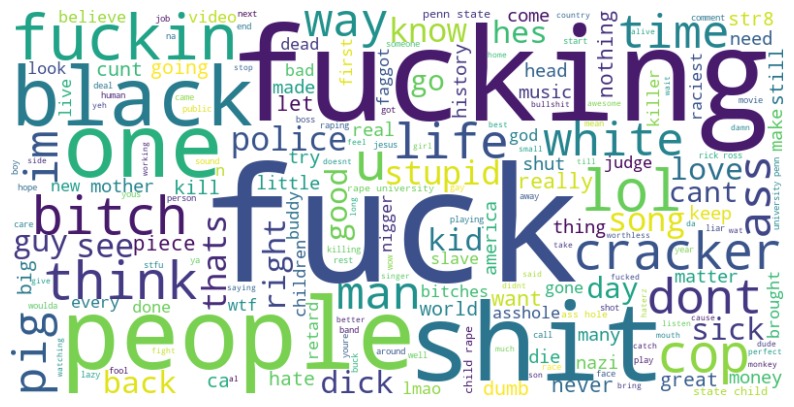

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from transformers import BertTokenizer, BertForSequenceClassification
import torch

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

def predict_cyberbullying(X, y):
    # Train the classification model (you can use any model here)
    model = LogisticRegression()
    pipeline = build_pipeline(model)
    pipeline.fit(X, y)

    # Predict the labels for all texts
    y_pred = pipeline.predict(X)

    return y_pred

def generate_word_cloud(texts):
    # Combine all texts into a single string
    combined_text = ' '.join(texts)
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def nlp_pipeline(file_path, target_column='oh_label', text_column='Text'):
    # Read the dataset
    df = pd.read_csv(file_path)
    df = df.drop(['UserIndex', 'index'], axis=1)
    df.rename(columns={target_column: 'Label'}, inplace=True)
    
    # Text Preprocessing
    df['processed_text'] = df[text_column].apply(preprocess_text)
    
    # Word Frequency Visualization
    word_freq = df['processed_text'].str.split(expand=True).stack().value_counts().head(20)
    plt.figure(figsize=(10, 6))
    word_freq.plot(kind='bar', color='skyblue')
    plt.title('Top 20 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Sentiment Analysis
    df['Sentiment_Polarity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['Sentiment_Label'] = df['Sentiment_Polarity'].apply(lambda x: 'Positive' if x > 0 else ('Neutral' if x == 0 else 'Negative'))
    print("\nSentiment Analysis Results:")
    print(df[['Text', 'Sentiment_Polarity', 'Sentiment_Label']])
    
    # Feature Engineering
    cursed_words = ['fuck', 'shit', 'asshole', 'bitch', 'damn', 'crap', 'hell', 'bastard', 'piss', 'dick', 'pussy', 'mf', 'mother fucker', 'behenchod']
    df['No_of_Cursed_Words'] = df['Text'].apply(lambda x: sum(1 for word in x.lower().split() if word in cursed_words))
    
    # Correlation Matrix
    numeric_df = df.select_dtypes(include='number')
    corr_matrix = numeric_df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
    plt.title('Correlation Matrix Heatmap')
    plt.show()
    
    # Feature Selection
    numerical_columns = numeric_df.columns.tolist()
    if 'Label' in numerical_columns:
        numerical_columns.remove('Label')
    print("\nNumerical columns after feature selection:", numerical_columns)
    
    # Modeling
    X = df['processed_text']

    y = df['Label']
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    # Evaluate models
    results = evaluate_model(X_train.ravel(), X_test.ravel(), y_train, y_test)
    
    # Print results
    for name, accuracy, auc_score in results:
        print(f"{name}: Accuracy = {accuracy}, AUC = {auc_score}")
    
    # Predict cyberbullying and generate word cloud
    y_pred_cyberbullying = predict_cyberbullying(X, y)
    cyberbullying_texts = df.loc[y_pred_cyberbullying == 1, 'processed_text'].tolist()
    generate_word_cloud(cyberbullying_texts)

def build_pipeline(model):
    return Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', model)
    ])

def evaluate_model(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'LGBM': LGBMClassifier(),
        'SVM': SVC(probability=True),
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier()
    }

    results = []
    for name, model in models.items():
        pipeline = build_pipeline(model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if hasattr(model, 'predict_proba'):
            y_prob = pipeline.predict_proba(X_test)[:, 1]
            auc_score = roc_auc_score(y_test, y_prob)
        else:
            auc_score = None
        results.append((name, accuracy, auc_score))
    return results
# Example usage:
nlp_pipeline('cyberbullying/youtube_parsed_dataset.csv')


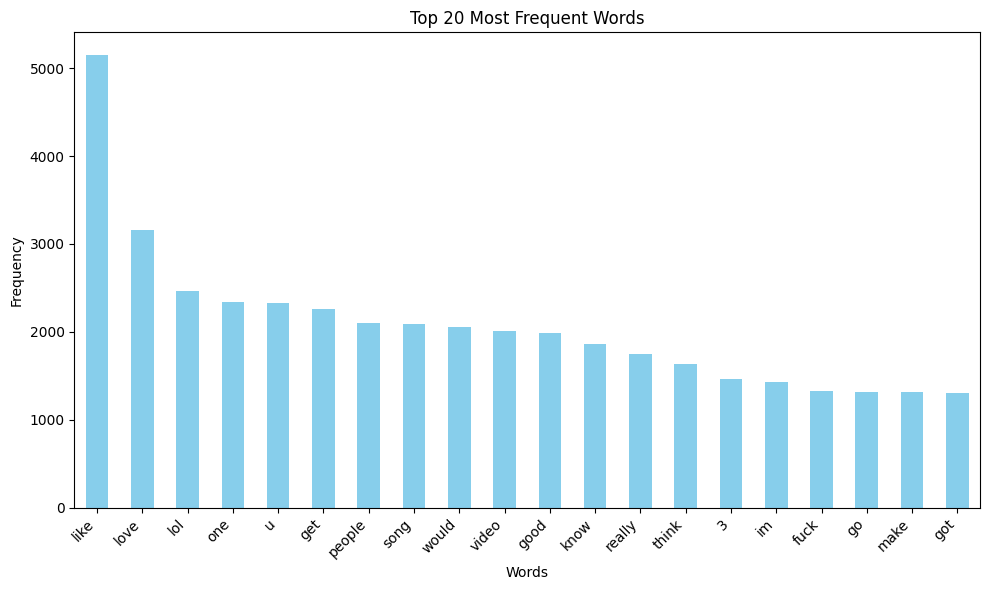


Sentiment Analysis Results:
                                                   Text  Sentiment_Polarity  \
0     Does N.e.bodyelse Hear her Crazy ass Screamin ...           -0.040000   
1     There are so many things that are incorrect wi...           -0.110606   
2     3:26 hahah my boyfriend showed this song to me...            0.433333   
3     dick beyonce fuck y a ass hole you are truely ...           -0.186975   
4     DongHaeTaemin and Kai ;A; luhansehun and bacon...            0.482143   
...                                                 ...                 ...   
3459  She pretty I love this song I miss the old kel...            0.304464   
3460  Status-Online Im ZxkillergirlzX! I'm Zxkillerg...            0.000000   
3461  JR so cute EXO M Better I agree like yeah yeah...            0.370833   
3462                                                ! !            0.000000   
3463  great video and MERRY CHRISTMAS from greece :*...            0.332612   

     Sentiment_Label  

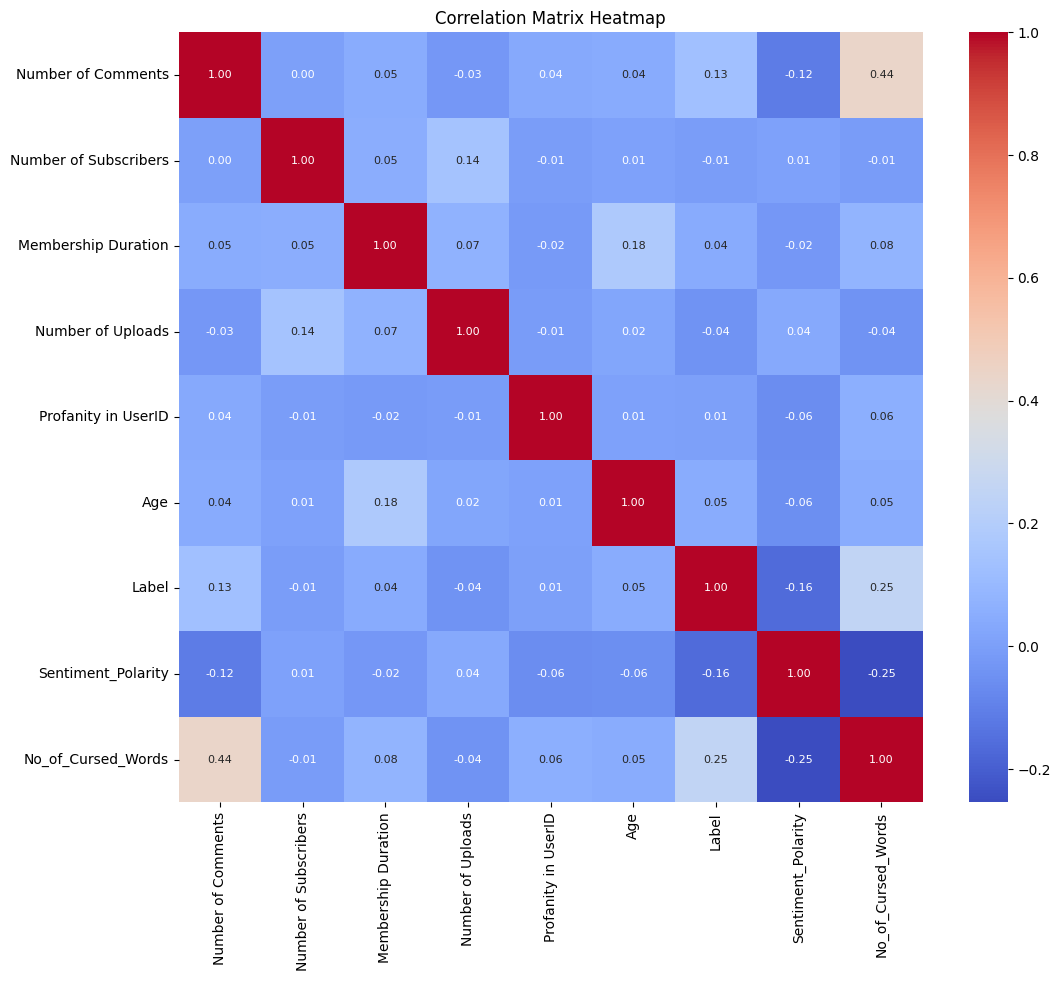


Numerical columns after feature selection: ['Number of Comments', 'Number of Subscribers', 'Membership Duration', 'Number of Uploads', 'Profanity in UserID', 'Age', 'Sentiment_Polarity', 'No_of_Cursed_Words']
Logistic Regression: AUC = 0.9712888888888888
Random Forest: AUC = 0.9999676767676768
XGBoost: AUC = 0.9883744107744108
[LightGBM] [Info] Number of positive: 2453, number of negative: 2422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86395
[LightGBM] [Info] Number of data points in the train set: 4875, number of used features: 3557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503179 -> initscore=0.012718
[LightGBM] [Info] Start training from score 0.012718
LGBM: AUC = 0.9941872053872054
SVM: AUC = 0.9974518518518518
KNN: AUC = 0.9876767676767677
Decision Tree: AUC = 0.

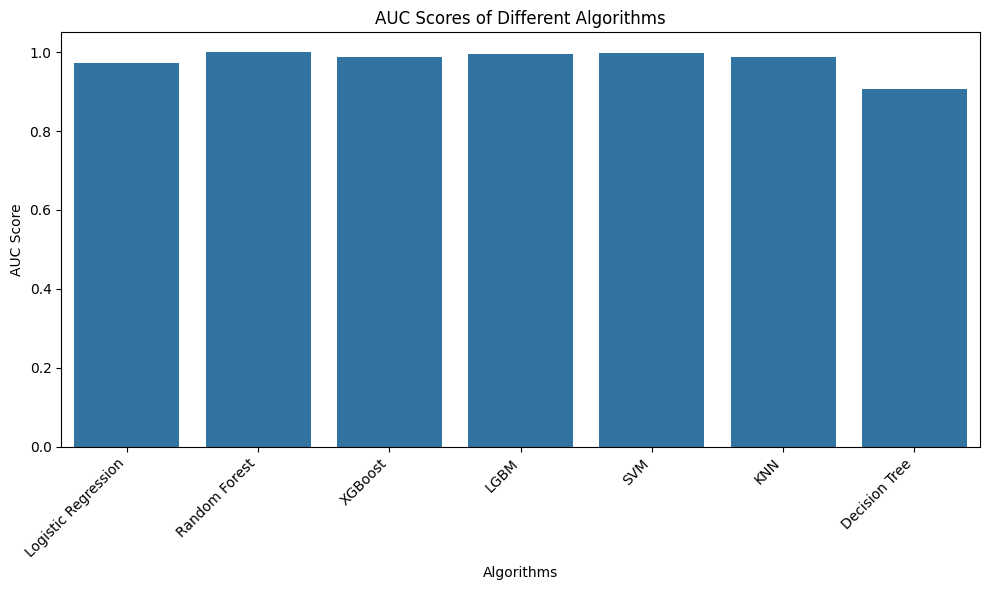

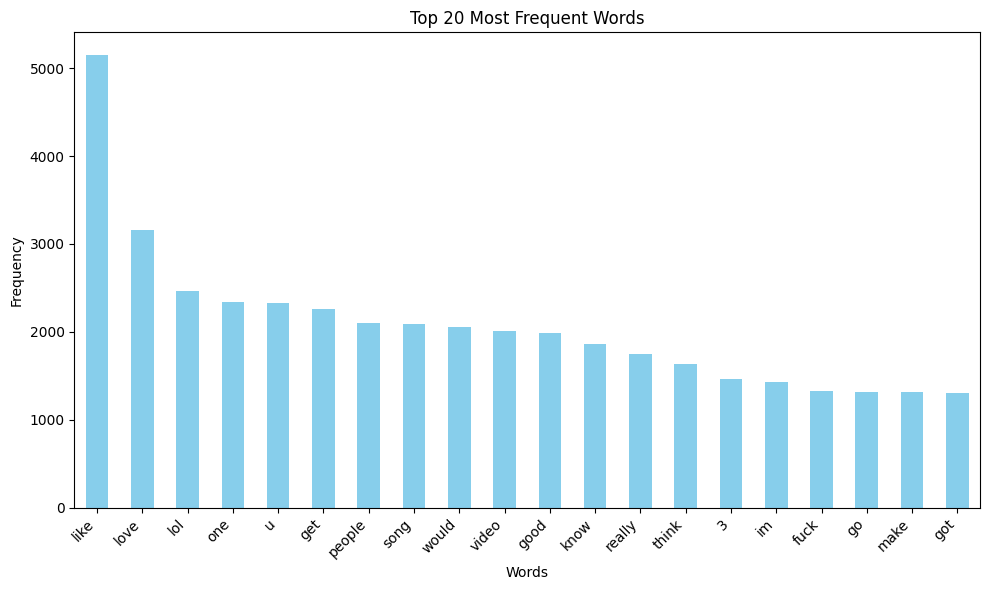


Sentiment Analysis Results:
                                                   Text  Sentiment_Polarity  \
0     Does N.e.bodyelse Hear her Crazy ass Screamin ...           -0.040000   
1     There are so many things that are incorrect wi...           -0.110606   
2     3:26 hahah my boyfriend showed this song to me...            0.433333   
3     dick beyonce fuck y a ass hole you are truely ...           -0.186975   
4     DongHaeTaemin and Kai ;A; luhansehun and bacon...            0.482143   
...                                                 ...                 ...   
3459  She pretty I love this song I miss the old kel...            0.304464   
3460  Status-Online Im ZxkillergirlzX! I'm Zxkillerg...            0.000000   
3461  JR so cute EXO M Better I agree like yeah yeah...            0.370833   
3462                                                ! !            0.000000   
3463  great video and MERRY CHRISTMAS from greece :*...            0.332612   

     Sentiment_Label  

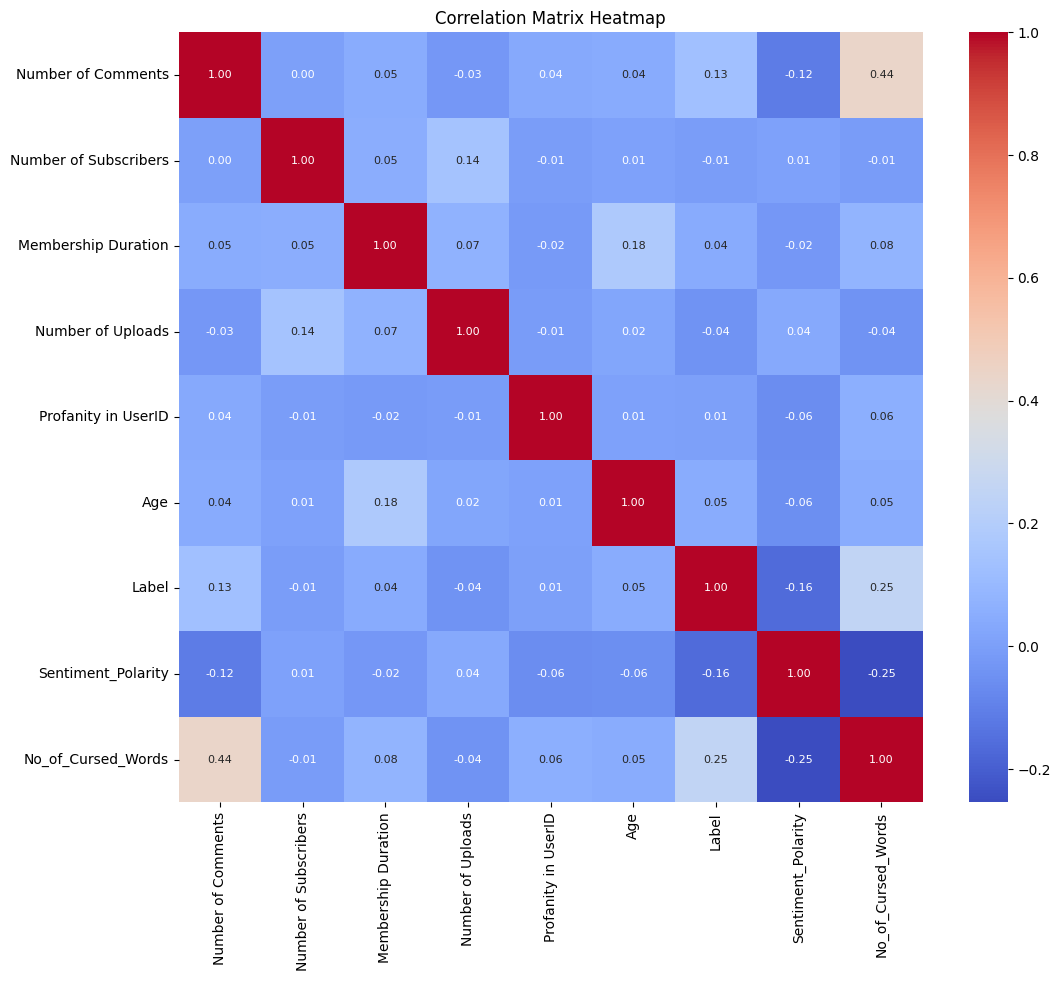


Numerical columns after feature selection: ['Number of Comments', 'Number of Subscribers', 'Membership Duration', 'Number of Uploads', 'Profanity in UserID', 'Age', 'Sentiment_Polarity', 'No_of_Cursed_Words']
Logistic Regression: AUC = 0.9712888888888888
Random Forest: AUC = 0.9999569023569024
XGBoost: AUC = 0.9883744107744108
[LightGBM] [Info] Number of positive: 2453, number of negative: 2422
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86395
[LightGBM] [Info] Number of data points in the train set: 4875, number of used features: 3557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503179 -> initscore=0.012718
[LightGBM] [Info] Start training from score 0.012718
LGBM: AUC = 0.9941872053872054
SVM: AUC = 0.9974518518518518
KNN: AUC = 0.9876767676767677
Decision Tree: AUC = 0.900393265993266


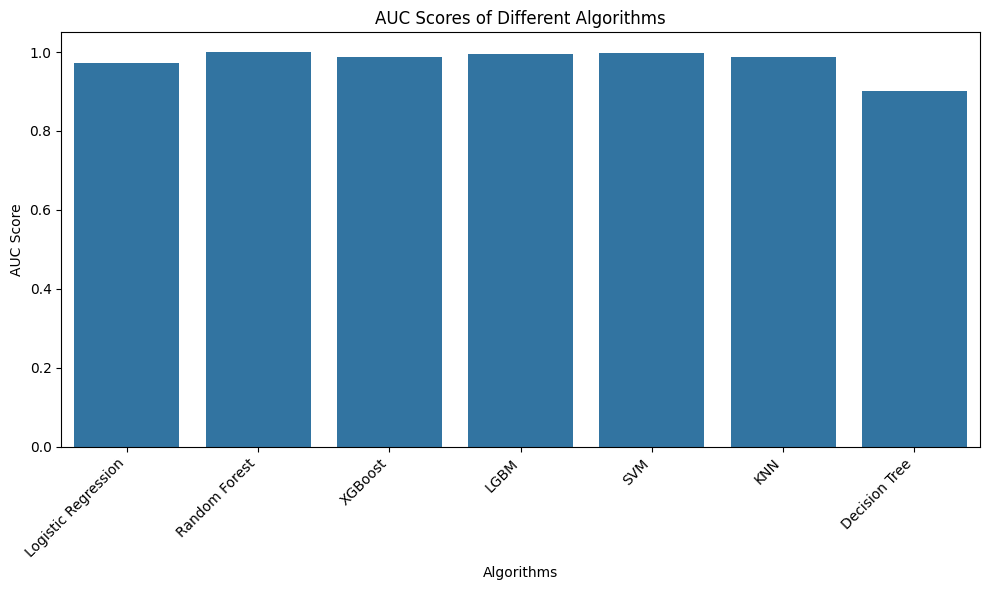

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from transformers import BertTokenizer, BertForSequenceClassification
import torch

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

def predict_cyberbullying(X_train, y_train, X_test):
    # Train the classification model (you can use any model here)
    model = LogisticRegression()
    pipeline = build_pipeline(model)
    pipeline.fit(X_train, y_train)

    # Predict the labels for all texts
    y_pred = pipeline.predict(X_test)

    return y_pred

def generate_word_cloud(texts):
    # Combine all texts into a single string
    combined_text = ' '.join(texts)
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def nlp_pipeline(file_path, target_column='oh_label', text_column='Text'):
    # Read the dataset
    df = pd.read_csv(file_path)
    df = df.drop(['UserIndex', 'index'], axis=1)
    df.rename(columns={target_column: 'Label'}, inplace=True)
    
    # Text Preprocessing
    df['processed_text'] = df[text_column].apply(preprocess_text)
    
    # Word Frequency Visualization
    word_freq = df['processed_text'].str.split(expand=True).stack().value_counts().head(20)
    plt.figure(figsize=(10, 6))
    word_freq.plot(kind='bar', color='skyblue')
    plt.title('Top 20 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Sentiment Analysis
    df['Sentiment_Polarity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['Sentiment_Label'] = df['Sentiment_Polarity'].apply(lambda x: 'Positive' if x > 0 else ('Neutral' if x == 0 else 'Negative'))
    print("\nSentiment Analysis Results:")
    print(df[['Text', 'Sentiment_Polarity', 'Sentiment_Label']])
    
    # Feature Engineering
    cursed_words = ['fuck', 'shit', 'asshole', 'bitch', 'damn', 'crap', 'hell', 'bastard', 'piss', 'dick', 'pussy', 'mf', 'mother fucker', 'behenchod']
    df['No_of_Cursed_Words'] = df['Text'].apply(lambda x: sum(1 for word in x.lower().split() if word in cursed_words))
    
    # Correlation Matrix
    numeric_df = df.select_dtypes(include='number')
    corr_matrix = numeric_df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
    plt.title('Correlation Matrix Heatmap')
    plt.show()
    
    # Feature Selection
    numerical_columns = numeric_df.columns.tolist()
    if 'Label' in numerical_columns:
        numerical_columns.remove('Label')
    print("\nNumerical columns after feature selection:", numerical_columns)
    
    # Modeling
    X = df['processed_text']
    y = df['Label']
    
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    # Train and evaluate models
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'LGBM': LGBMClassifier(),
        'SVM': SVC(probability=True),
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier()
    }

    results = {}
    for name, model in models.items():
        pipeline = build_pipeline(model)
        pipeline.fit(X_train.ravel(), y_train)
        y_prob = pipeline.predict_proba(X_test.ravel())[:, 1]
        auc_score = roc_auc_score(y_test, y_prob)
        results[name] = auc_score
        print(f"{name}: AUC = {auc_score}")
    
    # Plot AUC scores
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(results.keys()), y=list(results.values()))
    plt.title('AUC Scores of Different Algorithms')
    plt.xlabel('Algorithms')
    plt.ylabel('AUC Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
nlp_pipeline('cyberbullying/youtube_parsed_dataset.csv')

       